# 1 - Import requirements

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

from tqdm import tqdm

# 2 - Prepare data

In [2]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

In [18]:
def load_shape(shape_path):
    with open(shape_path, 'r') as f:
        shape = f.readlines()
        n_samples = int(shape[0])
        seq_len = int(shape[1])
        n_features = int(shape[2])
    return n_samples, seq_len, n_features

class TradingDataset(Dataset):
    def __init__(self, save_path, n_samples, sequence_length, n_features):
        self.save_path = save_path
        self.n_samples = n_samples
        self.sequences = np.memmap(f'{save_path}/sequences.dat', dtype=np.float32, mode='r', 
                                 shape=(n_samples, sequence_length, n_features))
        self.labels = np.memmap(f'{save_path}/labels.dat', dtype=np.int64, mode='r', 
                              shape=(n_samples,))
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].copy()  # Tạo bản sao writable
        lbl = self.labels[idx].copy()
        return torch.from_numpy(seq).float(), torch.from_numpy(np.array([lbl])).long()[0]

def prepare_transformer_input(train_shape_path, val_shape_path, test_shape_path, data_path, batch_size=32):    
    n_train_samples, sequence_length, n_features = load_shape(train_shape_path)
    n_val_samples, _, _ = load_shape(val_shape_path)
    n_test_samples, _, _ = load_shape(test_shape_path)
    
    train_path = f'{data_path}/train'
    val_path = f'{data_path}/val'
    test_path = f'{data_path}/test'
    
    # Tạo datasets
    train_dataset = Subset(TradingDataset(train_path, n_train_samples, sequence_length, n_features), 
                           range(n_train_samples - 400000, n_train_samples))
    val_dataset = Subset(TradingDataset(val_path, n_val_samples, sequence_length, n_features), 
                           range(n_val_samples - 50000, n_val_samples))
    test_dataset = Subset(TradingDataset(test_path, n_test_samples, sequence_length, n_features), 
                           range(n_test_samples - 10000, n_test_samples))
    
    # Tạo dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [19]:
train_shape_path = 'data/train/train_shape.txt'
val_shape_path = 'data/val/val_shape.txt'
test_shape_path = 'data/test/test_shape.txt'


train_loader, val_loader, test_loader = prepare_transformer_input(
    train_shape_path, val_shape_path, test_shape_path,
    data_path='data',
    batch_size=64
)

In [20]:
# Kiểm tra
sample_batch = next(iter(train_loader))
print("Batch input shape:", sample_batch[0].shape)
print("Batch labels shape:", sample_batch[1].shape)
print("\nExample input shape for Transformer:", sample_batch[0][0].shape)
print(sample_batch[0][0])
print("Number of batches:", len(train_loader))

Batch input shape: torch.Size([64, 60, 24])
Batch labels shape: torch.Size([64])

Example input shape for Transformer: torch.Size([60, 24])
tensor([[ 1.4655e+03,  1.4655e+03,  1.4647e+03,  ..., -1.0000e+00,
         -4.3388e-01, -9.0097e-01],
        [ 1.4647e+03,  1.4649e+03,  1.4633e+03,  ..., -1.0000e+00,
         -4.3388e-01, -9.0097e-01],
        [ 1.4636e+03,  1.4638e+03,  1.4630e+03,  ..., -1.0000e+00,
         -4.3388e-01, -9.0097e-01],
        ...,
        [ 1.4620e+03,  1.4622e+03,  1.4618e+03,  ..., -9.6593e-01,
         -4.3388e-01, -9.0097e-01],
        [ 1.4622e+03,  1.4624e+03,  1.4615e+03,  ..., -9.6593e-01,
         -4.3388e-01, -9.0097e-01],
        [ 1.4615e+03,  1.4615e+03,  1.4606e+03,  ..., -9.6593e-01,
         -4.3388e-01, -9.0097e-01]])
Number of batches: 6250


In [29]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class TradingTransformer(nn.Module):
    def __init__(self, 
                 num_features, 
                 num_classes=3, 
                 d_model=512,
                 nhead=8,
                 num_layers=6,
                 dropout=0.1):
        super().__init__()
        
        # 1. Feature Projection
        self.input_proj = nn.Linear(num_features, d_model)
        
        # 2. Positional Encoding (Learnable)
        self.pos_encoder = LearnablePositionalEncoding(d_model, dropout)
        
        # 3. Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True 
        )
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        
        # 4. Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, num_classes)
        )
        
        # 5. Initialize weights
        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src):
        """
        Args:
            src: Tensor shape [batch_size, seq_len, num_features]
        Returns:
            output: Tensor shape [batch_size, num_classes]
        """
        # Project input features
        x = self.input_proj(src)  # [B, S, D]
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer processing
        memory = self.transformer_encoder(x)  # [B, S, D]
        
        # Get last time step output
        last_output = memory[:, -1, :]  # [B, D]
        
        # Classification
        return self.classifier(last_output)


class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.position_emb = nn.Parameter(torch.zeros(max_len, d_model))
        nn.init.normal_(self.position_emb, mean=0, std=0.02)

    def forward(self, x):
        """
        Args:
            x: Tensor shape [B, S, D]
        """
        positions = self.position_emb[:x.size(1), :]  # [S, D]
        x = x + positions.unsqueeze(0)  # [B, S, D]
        return self.dropout(x)

In [30]:
N_FEATURES = 24
model = TradingTransformer(num_features=N_FEATURES)

model(sample_batch[0]).shape, sample_batch[1].shape

(torch.Size([64, 3]), torch.Size([64]))

In [31]:
from torchinfo import summary
print(summary(model, (64, 60, 24)))

Layer (type:depth-idx)                        Output Shape              Param #
TradingTransformer                            [64, 3]                   --
├─Linear: 1-1                                 [64, 60, 512]             12,800
├─LearnablePositionalEncoding: 1-2            [64, 60, 512]             2,560,000
│    └─Dropout: 2-1                           [64, 60, 512]             --
├─TransformerEncoder: 1-3                     [64, 60, 512]             --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [64, 60, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-2      [64, 60, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-3      [64, 60, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-4      [64, 60, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-5      [64, 60, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-6      [64

In [32]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        """
        patience: Số epoch chờ mà không cải thiện trước khi dừng
        min_delta: Độ cải thiện tối thiểu để coi là tốt hơn
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            
def eval_model(model, val_loader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, unit='batch', desc='\tEvaluating: '):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, criterion, optimizer, scheduler, device):
    model.to(device)
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels in tqdm(train_loader, unit='batch', desc=f'\tTraining: '):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    scheduler.step()
    
    return epoch_loss, epoch_acc

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [34]:
NUM_EPOCHS = 20
PATIENCE = 3
MIN_DELTA = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
    
train_losses = []
train_accs = []
val_losses = []
val_accs = []

early_stopping = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

for epoch in range(NUM_EPOCHS):
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, DEVICE)
    val_loss, val_acc = eval_model(model, val_loader, criterion, DEVICE)
    
    print(f'\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'\tVal Loss: {val_loss:.4f}, Train Accuracy: {val_acc:.2f}%')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Kiểm tra Early Stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break
    print('===================================================')

Epoch [1/20]


	Training:  46%|████▌     | 2884/6250 [07:36<08:53,  6.31batch/s]


KeyboardInterrupt: 

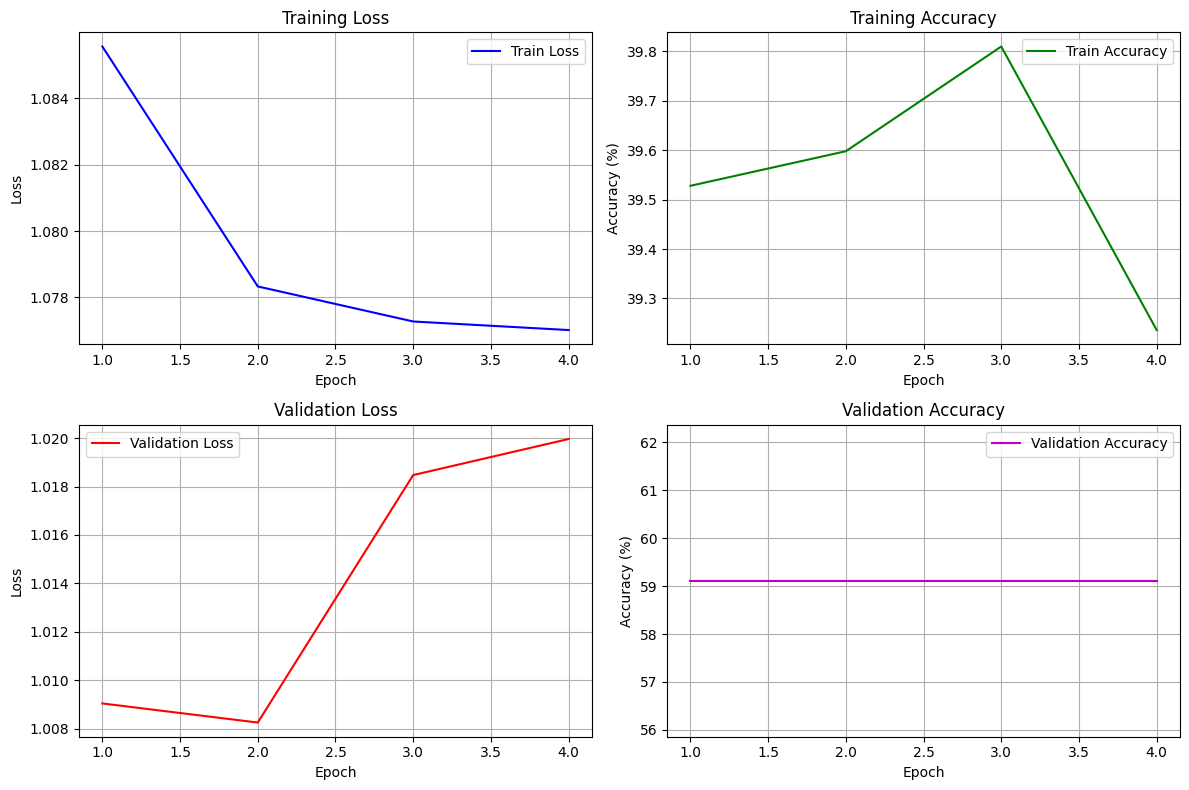

In [12]:
import matplotlib.pyplot as plt
def plot_training_results(train_losses, train_accs, val_losses, val_accs):
    """
    Vẽ biểu đồ kết quả huấn luyện: loss và accuracy cho train và validation.
    
    Parameters:
    - train_losses: List các giá trị loss của train qua các epoch
    - train_accs: List các giá trị accuracy của train qua các epoch
    - val_losses: List các giá trị loss của validation qua các epoch
    - val_accs: List các giá trị accuracy của validation qua các epoch
    """
    epochs = range(1, len(train_losses) + 1)
    
    # Tạo figure với 2x2 subplot
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Train Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Train Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accs, 'g-', label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot 3: Validation Loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot 4: Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_accs, 'm-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Điều chỉnh layout và hiển thị
    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, train_accs, val_losses, val_accs)

In [13]:
model_path = 'save/models'
torch.save(model.state_dict(), f'{model_path}/simple_transformer.pth')

In [14]:
def test_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)  # [B, seq_len, n_features]
            batch_y = batch_y.to(device)

            outputs = model(batch_x)  # Expecting [B, num_classes]
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    target_names = ['BUY', 'SELL', 'HOLD']
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4, zero_division=0))

In [15]:
test_model(model, train_loader, DEVICE)

Classification Report:
              precision    recall  f1-score   support

         BUY     0.0000    0.0000    0.0000     37884
        SELL     0.0000    0.0000    0.0000     23096
        HOLD     0.3902    1.0000    0.5614     39020

    accuracy                         0.3902    100000
   macro avg     0.1301    0.3333    0.1871    100000
weighted avg     0.1523    0.3902    0.2190    100000



In [16]:
test_model(model, val_loader, DEVICE)

Classification Report:
              precision    recall  f1-score   support

         BUY     0.0000    0.0000    0.0000      2406
        SELL     0.0000    0.0000    0.0000      1683
        HOLD     0.5911    1.0000    0.7430      5911

    accuracy                         0.5911     10000
   macro avg     0.1970    0.3333    0.2477     10000
weighted avg     0.3494    0.5911    0.4392     10000



In [17]:
test_model(model, test_loader, DEVICE)

Classification Report:
              precision    recall  f1-score   support

         BUY     0.0000    0.0000    0.0000       362
        SELL     0.0000    0.0000    0.0000       256
        HOLD     0.3820    1.0000    0.5528       382

    accuracy                         0.3820      1000
   macro avg     0.1273    0.3333    0.1843      1000
weighted avg     0.1459    0.3820    0.2112      1000

